## Predicting cab booking cancellations

The business problem tackled here is trying to improve customer service for <I>"YourCabs.com"</I>, a cab company in Bengaluru, India. The problem of interest is booking cancellations by the company due to unavailability of a car. The challenge is that cancellations can occur very close to the trip start time, thereby causing passengers inconvenience.

## Goal:
* The goal is to create a predictive model for classifying new bookings as to whether they will eventually get cancelled due to car unavailability. This is a classification task that includes misclassification costs.
* The cost of misclassifying an un-cancelled booking as a cancelled booking (cost=1 unit).
* The cost of misclassifying a cancelled booking as uncancelled booking (penalty of 100 units).

### Data
* <B>Data file name:</B> Kaggle_YourCabs_training.csv
* <B>File descriptions:</B> The training set (over 43,000 bookings). Includes the output Car_Cancellation and the misclassification costs in Cost_of_error.
* ####Data fields:
    * <u>id</u> - booking ID
    * <u>user_id</u> - the ID of the customer (based on mobile number)
    * <u>vehicle_model_id</u> - vehicle model type.
    * <u>package_id </u>- type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs & 30kms, 7=12hrs & 120kms)
    * <u>travel_type_id</u> - type of travel (1=long distance, 2= point to point, 3= hourly rental).
    * <u>from_area_id</u> - unique identifier of area. Applicable only for point-to-point travel and packages
    * <u>to_area_id </u>- unique identifier of area. Applicable only for point-to-point travel
    * <u>from_city_id</u> - unique identifier of city
    * <u>to_city_id</u> - unique identifier of city (only for intercity)
    * <u>from_date</u> - time stamp of requested trip start
    * <u>to_date </u>- time stamp of trip end
    * <u>online_booking </u>- if booking was done on desktop website
    * <u>mobile_site_booking </u>- if booking was done on mobile website
    * <u>booking_created </u>- time stamp of booking
    * <u>from_lat </u>- latitude of from area, <u>from_long</u> -  longitude of from area, <u>to_lat</u> - latitude of to area, <u>to_long</u> - longitude of to area
    * <u>Car_Cancellation</u> - whether the booking was cancelled (1) or not (0) due to unavailability of a car.
    * <u>Cost_of_error</u> - the cost incurred if the booking is misclassified. For an un-cancelled booking, the cost of misclassificaiton is 1. For a cancelled booking, the cost of misclassificaiton is 100 uniits.

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#The classifier used for this problem is "RandomForestClassifier"
from sklearn.ensemble import RandomForestClassifier

# The error metric. In this case, we will use AUC- Area Under the Curve(aka ROC/c-stat)
from sklearn.metrics import roc_auc_score

# An efficient data structure.
import pandas as pd

#Loading data
X=pd.read_csv("Kaggle_YourCabs_training.csv")
y = X.pop("Car_Cancellation")

In [3]:
#The column 'Cost_of_error'(cost of missclassification) calculated according to the column "Car_Cancellation", which is to be predicted. 
#So lets drop this column.
X.drop(["Cost_of_error"], axis=1, inplace=True)

In [4]:
X.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,1/1/2013 2:00,NaN,0,0,1/1/2013 1:39,12.924150,77.672290,12.927320,77.635750
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 2:25,12.966910,77.749350,12.927680,77.626640
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,1/1/2013 3:30,NaN,0,0,1/1/2013 3:08,12.937222,77.626915,13.047926,77.597766
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,1/1/2013 5:45,NaN,0,0,1/1/2013 4:39,12.989990,77.553320,12.971430,77.639140
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,1/1/2013 9:00,NaN,0,0,1/1/2013 7:53,12.845653,77.677925,12.954340,77.600720


In [5]:
X.describe()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,to_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long
count,43431.000000,43431.000000,43431.00000,7550.000000,43431.000000,43343.000000,34293.000000,16345.000000,1588.000000,25541.000000,43431.000000,43431.000000,43338.000000,43338.000000,34293.000000,34293.000000
mean,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,41507.974840,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595
std,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,305.144945,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045
min,132512.000000,16.000000,1.00000,1.000000,1.000000,2.000000,2.000000,1.000000,4.000000,25569.020830,0.000000,0.000000,12.776630,77.386930,12.776630,77.386930
25%,145778.000000,24614.000000,12.00000,1.000000,2.000000,393.000000,393.000000,15.000000,32.000000,41480.521110,0.000000,0.000000,12.926450,77.593661,12.951850,77.582030
50%,159248.000000,31627.000000,12.00000,2.000000,2.000000,590.000000,541.000000,15.000000,49.000000,41517.761550,0.000000,0.000000,12.968887,77.635750,12.982750,77.645030
75%,172578.500000,39167.000000,24.00000,2.000000,2.000000,1089.000000,1054.000000,15.000000,108.000000,41558.914630,1.000000,0.000000,13.007750,77.688900,13.199560,77.706880
max,185941.000000,48730.000000,91.00000,7.000000,3.000000,1403.000000,1403.000000,31.000000,203.000000,41678.275680,1.000000,1.000000,13.366072,77.786420,13.366072,77.786420


In [6]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,to_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,NaN,0,0,12.924150,77.672290,12.927320,77.635750
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,NaN,0,0,12.966910,77.749350,12.927680,77.626640
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,NaN,0,0,12.937222,77.626915,13.047926,77.597766
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,NaN,0,0,12.989990,77.553320,12.971430,77.639140
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,NaN,0,0,12.845653,77.677925,12.954340,77.600720


# Handling missing values
* Here, strategy used to handle missing values is filling all 'NaN' values with number 'zero'(0).
* Columns 'package_id', 'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'to_date', 'from_lat', 'from_long', 'to_lat', 'to_long' have missing values. So, fill all the missing values in these columns as '0'

In [7]:
#fill all the null values with '0'.
null_col=['package_id', 'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'to_date', 'from_lat', 'from_long', 'to_lat', 'to_long']
for i in range(0, 10, 1):
    X[null_col[i]].fillna(0, inplace=True)

# Model Creation
At this point I will define a test and train set. I will use train to train my model and test to see how accurate the model is.
###Let's build our first model: This model is built using only numeric columns of the data set


In [8]:
# Make train and test datasets
from sklearn.cross_validation import train_test_split
import numpy as np
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X[numeric_variables], y, test_size=.2)

/Users/icu639/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model.fit(X_train, y_train)

roc = roc_auc_score(y_test, model.predict(X_test))
print "AUC: ", roc

AUC:  0.617062000612


We now have a benchmark. This isn't good for this dataset; however, it provides us a benchmark for improvement. Before changing parameters for the Random Forest, let's whip this dataset into shape.

# Let's build our model using both numerical and categorical columns:

In [11]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [12]:
describe_categorical(X)

,from_date,booking_created
count,43431,43431
unique,20377,39349
top,10/12/2013 6:00,10/31/2013 10:30
freq,20,18


####Extracting new feature:
From the categorical variables, it looks like the differece between from_date and booking_created is important (i.e number of days remaining for travl form the date of booking a cab). Because there may be chances that (less/more) number of days remaining for the trip might relate the car cancellation. So, 'days_rem' is the new column created for remaining days.

In [13]:
#Finding difference between time stamp of requested trip start(X.from_date) and time stamp of booking(X.booking_created)
import datetime
days_rem=[]
for i in range(0, X.shape[0], 1):
    from_date=datetime.datetime.strptime(X.from_date.get_value(i), '%m/%d/%Y %H:%M')
    booking_date=datetime.datetime.strptime(X.booking_created.get_value(i), '%m/%d/%Y %H:%M')
    diff=from_date-booking_date
    days_rem.append(diff.days)

In [14]:
#Add newly created column 'days_rem' to X
X['days_rem']=days_rem

####Splitting existing feature:
It is better to split the date variables (from_date and booking_crated) as month, day and time to get better categories.

In [15]:
import time
def handle_date(x):
    '''takes date as input
    splits the date variable as day, month, year, hours 
    returns day, month and hour'''
    
    seconds= int(time.mktime(time.strptime(x, '%m/%d/%Y %H:%M'))) - time.timezone
    timeStamp=time.strftime("%a,%d %b %Y %H:%M:%S", time.gmtime(seconds))
    day, date=timeStamp.split(',')
    dd, mmm, yyyy, T= date.split(' ')
    hour, minut, sec = T.split(":")
    return day, mmm, hour

In [16]:
def split_date_col(date_col):
    '''takes each date column from data set 'X'
    calls "handle_date()" fn
    returns list of months, days and hours for corresponding date column'''
    
    months=[]
    days=[]
    hours=[]
    for i in range(0, X.shape[0], 1):
        d, m, s= handle_date(date_col.get_value(i))
        months.append(m)
        days.append(d)
        hours.append(s)
    return months, days, hours

In [17]:
#Splitting 'Date' columns into 3 different columns(month, day, time)
from_month, from_weekday, from_time= split_date_col(X.from_date)
booing_month, booking_weekday, booking_time=split_date_col(X.booking_created)

In [18]:
#Add newly created columns by  splitting "from_date" into from_month, from_weekday, from_time
X['from_month']=from_month
X['from_weekday']=from_weekday
X['from_time']=from_time
X.drop(["from_date"], axis=1, inplace=True)

In [19]:
#Add newly created columns by  splitting "booking_created" into booing_month, booking_weekday, booking_time
X['booking_month']=booing_month
X['booking_weekday']=booking_weekday
X['booking_time']=booking_time
X.drop(["booking_created"], axis=1, inplace=True)

In [20]:
# Droping the variables that I don't feel like dealing with (id, user_id, to_date looks like worthless)
X.drop(["id", "user_id", "to_date"], axis=1, inplace=True)

In [21]:
#There are many categorical variables
categorical_variables = ['from_month', 'from_weekday', 'booking_month', 'booking_weekday', 'vehicle_model_id', 'package_id', 'travel_type_id', 'from_city_id', 'online_booking', 'mobile_site_booking', 'to_city_id']

for variable in categorical_variables:
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [22]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,from_area_id,to_area_id,from_lat,from_long,to_lat,to_long,days_rem,from_time,booking_time,from_month_Apr,from_month_Aug,from_month_Dec,from_month_Feb,from_month_Jan,from_month_Jul,from_month_Jun,from_month_Mar,from_month_May,from_month_Nov,from_month_Oct,from_month_Sep,from_weekday_Fri,from_weekday_Mon,from_weekday_Sat,from_weekday_Sun,from_weekday_Thu,from_weekday_Tue,from_weekday_Wed,booking_month_Apr,booking_month_Aug,booking_month_Feb,booking_month_Jan,booking_month_Jul,booking_month_Jun,booking_month_Mar,booking_month_May,booking_month_Nov,booking_month_Oct,booking_month_Sep,booking_weekday_Fri,booking_weekday_Mon,booking_weekday_Sat,booking_weekday_Sun,booking_weekday_Thu,booking_weekday_Tue,booking_weekday_Wed,vehicle_model_id_1,vehicle_model_id_10,vehicle_model_id_12,vehicle_model_id_13,vehicle_model_id_14,vehicle_model_id_17,vehicle_model_id_23,vehicle_model_id_24,vehicle_model_id_28,vehicle_model_id_30,vehicle_model_id_36,vehicle_model_id_39,vehicle_model_id_43,vehicle_model_id_54,vehicle_model_id_64,vehicle_model_id_65,vehicle_model_id_69,vehicle_model_id_70,vehicle_model_id_72,vehicle_model_id_75,vehicle_model_id_76,vehicle_model_id_85,vehicle_model_id_86,vehicle_model_id_87,vehicle_model_id_89,vehicle_model_id_90,vehicle_model_id_91,package_id_0.0,package_id_1.0,package_id_2.0,package_id_3.0,package_id_4.0,package_id_5.0,package_id_6.0,package_id_7.0,travel_type_id_1,travel_type_id_2,travel_type_id_3,from_city_id_0.0,from_city_id_1.0,from_city_id_15.0,from_city_id_31.0,online_booking_0,online_booking_1,mobile_site_booking_0,mobile_site_booking_1,to_city_id_0.0,to_city_id_4.0,to_city_id_5.0,to_city_id_8.0,to_city_id_10.0,to_city_id_11.0,to_city_id_12.0,to_city_id_13.0,to_city_id_14.0,to_city_id_16.0,to_city_id_17.0,to_city_id_18.0,to_city_id_20.0,to_city_id_23.0,to_city_id_24.0,to_city_id_25.0,to_city_id_28.0,to_city_id_29.0,to_city_id_30.0,to_city_id_31.0,to_city_id_32.0,to_city_id_36.0,to_city_id_37.0,to_city_id_41.0,to_city_id_42.0,to_city_id_44.0,to_city_id_45.0,to_city_id_48.0,to_city_id_49.0,to_city_id_50.0,to_city_id_51.0,to_city_id_52.0,to_city_id_53.0,to_city_id_55.0,to_city_id_56.0,to_city_id_57.0,to_city_id_58.0,to_city_id_60.0,to_city_id_61.0,to_city_id_62.0,to_city_id_64.0,to_city_id_65.0,to_city_id_66.0,to_city_id_67.0,to_city_id_68.0,to_city_id_69.0,to_city_id_72.0,to_city_id_75.0,to_city_id_76.0,to_city_id_77.0,to_city_id_80.0,to_city_id_82.0,to_city_id_85.0,to_city_id_88.0,to_city_id_89.0,to_city_id_94.0,to_city_id_97.0,to_city_id_108.0,to_city_id_109.0,to_city_id_110.0,to_city_id_111.0,to_city_id_113.0,to_city_id_114.0,to_city_id_115.0,to_city_id_116.0,to_city_id_119.0,to_city_id_120.0,to_city_id_121.0,to_city_id_125.0,to_city_id_126.0,to_city_id_131.0,to_city_id_132.0,to_city_id_133.0,to_city_id_134.0,to_city_id_135.0,to_city_id_137.0,to_city_id_139.0,to_city_id_142.0,to_city_id_144.0,to_city_id_146.0,to_city_id_147.0,to_city_id_148.0,to_city_id_149.0,to_city_id_151.0,to_city_id_152.0,to_city_id_154.0,to_city_id_157.0,to_city_id_160.0,to_city_id_161.0,to_city_id_162.0,to_city_id_163.0,to_city_id_164.0,to_city_id_165.0,to_city_id_166.0,to_city_id_167.0,to_city_id_168.0,to_city_id_169.0,to_city_id_170.0,to_city_id_172.0,to_city_id_173.0,to_city_id_176.0,to_city_id_178.0,to_city_id_179.0,to_city_id_182.0,to_city_id_184.0,to_city_id_185.0,to_city_id_186.0,to_city_id_187.0,to_city_id_189.0,to_city_id_190.0,to_city_id_191.0,to_city_id_192.0,to_city_id_196.0,to_city_id_197.0,to_city_id_198.0,to_city_id_200.0,to_city_id_203.0
0,83.0,448.0,12.924150,77.672290,12.927320,77.635750,0,02,01,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1010.0,540.0,12.966910,

In [23]:
# Make train and test datasets
from sklearn.cross_validation import train_test_split
import numpy as np
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [24]:
model = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model.fit(X_train, y_train)

roc = roc_auc_score(y_test, model.predict(X_test))
print "AUC: ", roc

AUC:  0.598632853873


This is not a better model and also parameters are not tuned properly. So, it is better to try some different parameters for the model.

# Best model estimater
* ####Parameters to test are:
    * <b>n_estimators</b>: The number of trees in the forest.
    * <b>max_features</b>: The number of features to consider when looking for the best split.
    * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.
    * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model.

In [25]:
from sklearn.grid_search import GridSearchCV
n_estimators = [300,400,500]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [3,5,7]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

/Users/icu639/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [26]:
#fit the model
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [27]:
#best and final model
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [28]:
best_rfc = estimator.best_estimator_

In [29]:
#accuracy of  the final model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.939334637965


###Classification report

In [30]:
#Precision and Recall
from sklearn.metrics import classification_report
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      8073
          1       0.77      0.20      0.32       614

avg / total       0.93      0.94      0.92      8687



# Classification report gives Precision and Recall details.
   * Precision is the fraction of correctly identified examples of a class (ratio of true positives to all positives).
   * Recall is the fraction of observations classified in that class that was correctly classified.
   * Where high precision relates to a 'low false positive rate', and high recall relates to a 'low false negative rate'.
   * High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

####For this project:
* <u>Precision:</u> The model will correctly identify 93% of cab cancellation.   Conversely there is a 7% chance it will identify a non-cancelled booking as a cancelled booking.  (tp / tp+fp)

* <u>Recall:</u> out of the booking the model identified as cancelled, 94% of them will actually be cancelled. That is, our model 6% of the times may identify a cancelled booking as a non-cancelled booking. (tp / tp + fn)

In [31]:
#confusion matrix
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[8036   37]
 [ 490  124]]


# From confusion matrix:
* true positive(tp)=8033
* false positive(fp)=40
* false negetive(fn)=488

**Cost of error:** 
* fnx100=>488x100=48800 units (cost of miss-classification as non-cancelled instead cancelled)
* fpx1=>40x1=40units(cost of miss-classification as cancelled instead non-cancelled)

In [32]:
#AUC of final model
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.898065433861


Our final model is pretty good. So, we are 90% successful in predicting car cancellation.

####Following ROC curve is created by plotting the "true positive rate" against the "false positive rate".
* ROC curve, is a graphical plot that illustrates the performance of a binary classifier system

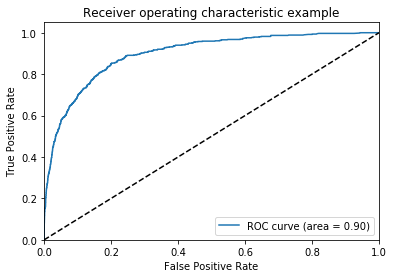

In [33]:
#ROC curve
from sklearn.metrics import roc_curve
import math

fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

##Model Performance
* Accuracy of the model:  0.939
* Precision and Recall are : 0.93 and 0.94  (that is pretty high)
* AUC score is 0.898. So, It is a very good model.

But, So far our entire strategy has been to fit a model as strongly as possible to our 20% of the data. 20% sample may not really reflect reality. 

Our model will overfit to the 20% holdout, and may not actually perform well in real life.

So, to overcome overfitting problem we use "Validation" technique. Now, for car cancellation prediction K-Fold Cross Validation is used.

### K-Fold Cross Validation
1.  Split the data into K chunks
2.  Train K models, retain a chunk for testing and use the other K-1 chunks for training.
3.  The result is K scores, which can be combined into a single average score for the model

In [34]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, X, y, cv=10)

In [35]:
scores

array([ 0.92771639,  0.91275322,  0.25535344,  0.72392356,  0.88349067,
        0.91871978,  0.91020032,  0.88763528,  0.85309694,  0.39405804])

In [36]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.766695 +/-  0.164498
95 percent probability that if this experiment were repeated over and over the average score would be between 0.602196 and 0.931193


### Result
Our single holdout AUC score was 0.898. But, after K-Fold Cross Validation it is clear that our model was overfitting.

So, actual AUC of the final model would be between  0.602305 and 0.931269 and . Average K-Fold CV score (AUC) is 0.766787

##Variable importance measures
Bar chart indicates the importance of the variables in descending order

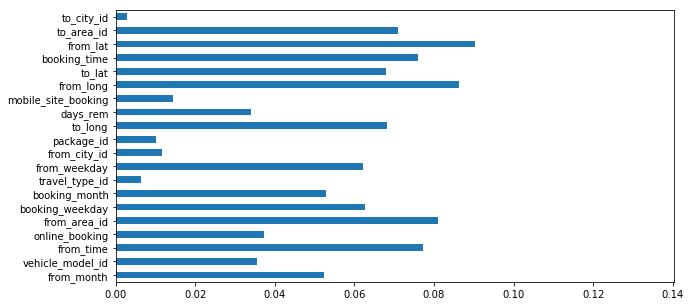

In [39]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = best_rfc.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, best_rfc.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort_values
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(best_rfc, X.columns, summarized_columns=categorical_variables)